# Chapter 11: Neural nets (Edited by Kang)

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

import dmba
from dmba import classificationSummary

%matplotlib inline

no display found. Using non-interactive Agg backend


## Table 11.2

In [2]:
example_df = dmba.load_data('TinyData.csv')

predictors = ['Fat', 'Salt']
outcome = 'Acceptance'

X = example_df[predictors]
y = example_df[outcome]
classes = sorted(y.unique())
MLPClassifier()
clf = MLPClassifier(hidden_layer_sizes=(3), activation='logistic', solver='lbfgs', random_state=1)
clf.fit(X, y)
clf.predict(X)

# Network structure
print('Intercepts')
print(clf.intercepts_)

print('Weights')
print(clf.coefs_)

# Prediction
print(pd.concat([
    example_df,
    pd.DataFrame(clf.predict_proba(X), columns=classes)
], axis=1))
# 결과를 너무 해석하기 힘들다. 

Intercepts
[array([0.13368045, 4.07247552, 7.00768104]), array([14.30748676])]
Weights
[array([[ -1.30656481,  -4.20427792, -13.29587332],
       [ -0.04399727,  -4.91606924,  -6.03356987]]), array([[ -0.27348313],
       [ -9.01211573],
       [-17.63504694]])]
   Obs.  Fat  Salt Acceptance   dislike      like
0     1  0.2   0.9       like  0.000490  0.999510
1     2  0.1   0.1    dislike  0.999994  0.000006
2     3  0.2   0.4    dislike  0.999741  0.000259
3     4  0.2   0.5    dislike  0.997368  0.002632
4     5  0.4   0.5       like  0.002133  0.997867
5     6  0.3   0.8       like  0.000075  0.999925


In [3]:
example_df.head()

,Obs.,Fat,Salt,Acceptance
0,1,0.2,0.9,like
1,2,0.1,0.1,dislike
2,3,0.2,0.4,dislike
3,4,0.2,0.5,dislike
4,5,0.4,0.5,like


## Table 11.3

In [4]:
classificationSummary(y, clf.predict(X), class_names=classes)

Confusion Matrix (Accuracy 1.0000)

        Prediction
 Actual dislike    like
dislike       3       0
   like       0       3


## Table 11.6

In [5]:
accidents_df = dmba.load_data('accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
# exclude the column for SUR_COND 9 = unknown
processed = pd.get_dummies(accidents_df, columns=['SUR_COND']).drop(columns=['SUR_COND_9'])

outcome = 'MAX_SEV_IR'
predictors = [c for c in processed.columns if c != outcome]

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
                    random_state=1)
clf.fit(train_X, train_y.values)

# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y, clf.predict(train_X))

# validation performance
classificationSummary(valid_y, clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8664)

       Prediction
Actual   0   1   2
     0 331   0   1
     1   0 180   0
     2  30  49   8
Confusion Matrix (Accuracy 0.8550)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 119   0
     2  24  33   5


## Grid search

In [6]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# train neural network with 2 hidden nodes
#clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
#                    random_state=1, max_iter=500)
#clf.fit(train_X, train_y)

param_grid = {
    'hidden_layer_sizes': [(1), (2), (3), (4), (5)], 
}
gridSearch = GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=10000), 
                          param_grid, cv=5, n_jobs=-1, return_train_score=True)
gridSearch.fit(train_X, train_y)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

Best score:  0.8647619047619047
Best parameters:  {'hidden_layer_sizes': 1}


In [7]:
display=['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']
print(pd.DataFrame(gridSearch.cv_results_)[display])

  param_hidden_layer_sizes  mean_test_score  std_test_score
0                        1         0.864762        0.009892
1                        2         0.864748        0.011403
2                        3         0.863081        0.012749
3                        4         0.859734        0.011501
4                        5         0.854748        0.010138


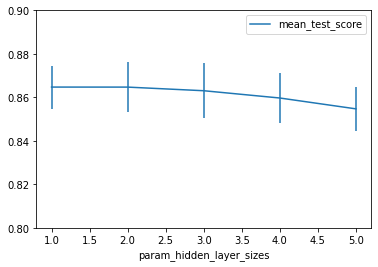

In [8]:
pd.DataFrame(gridSearch.cv_results_)[display].plot(x='param_hidden_layer_sizes', 
                                                   y='mean_test_score', yerr='std_test_score', ylim=(0.8, 0.9))
plt.show()